In [5]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [24]:
if torch.backends.mps.is_available():
    DEFAULT_DEVICE = torch.device("mps")
else:
    DEFAULT_DEVICE = 'cpu'
torch.set_default_device(DEFAULT_DEVICE)


In [25]:
a_np = np.random.random((3,2))
a = torch.from_numpy(a_np)
print(a.shape)

torch.Size([3, 2])


# torch autograd

![png](../images/Variable.png)

In [27]:
from torch.autograd import Variable

In [28]:
# requires_grad 表示是否对其求梯度，默认是False
x = Variable(torch.Tensor([3]), requires_grad=True)
y = Variable(torch.Tensor([5]), requires_grad=True)
z = 2 * x + y + 4

In [29]:
z.backward()

In [30]:
# x 的导数和 y 的导数
print('dz/dx: {}'.format(x.grad.data))
print('dz/dy: {}'.format(y.grad.data))

dz/dx: tensor([2.])
dz/dy: tensor([1.])


## Neural nets

In [41]:
class toy_net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv1d(3, 10, 1)

    def forward(self, x):
        out = self.conv1(x)
        return out

In [42]:
model = toy_net()

## Logistic Regression

In [6]:
train_dataset = datasets.FashionMNIST(
    root='../datasets', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.FashionMNIST(
    root='../datasets', train=False, transform=transforms.ToTensor())


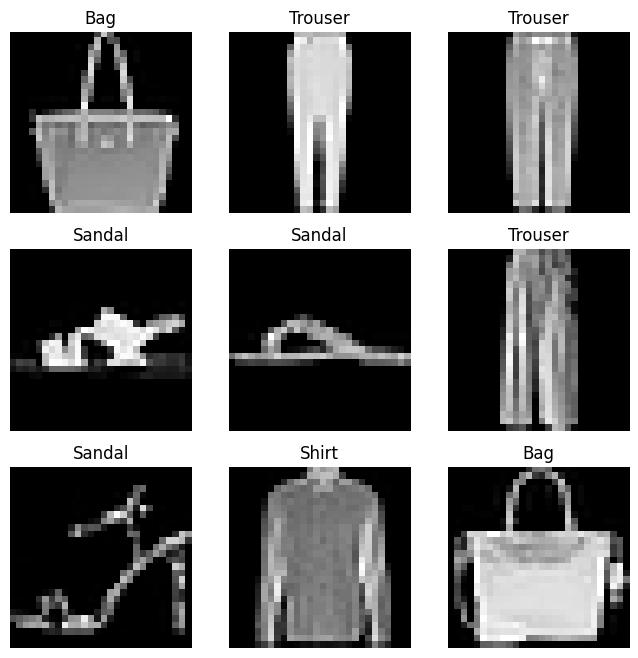

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    # print(sample_idx)
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
batch_size = 32
learning_rate = 1e-3
num_epochs=100

In [9]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


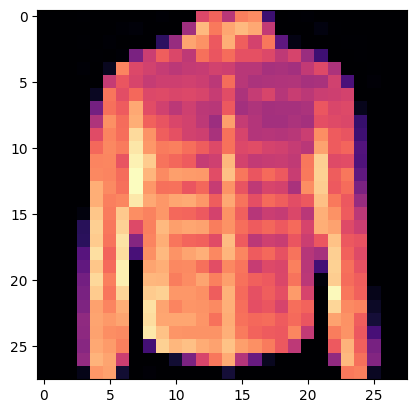

Label: 4


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="magma")
plt.show()
print(f"Label: {label}")

In [105]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim, n_class) -> None:
        super().__init__()
        self.logit = nn.Linear(in_dim, n_class)

    def forward(self, x, targets):
        B = x.size(0)
        img = x.view(B, -1) # batch dimension x num_pixels
        logits = self.logit(img)    
        if targets is None:
            loss = None
        else:
            targets = targets.view(B)
            # print(f"logits shape: {logits.shape} | target shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)
        return logits, loss

In [ ]:
img, label = next(iter(train_loader))
print('inputs:')
print(img.shape)
# print(xb)
print('targets:')
print(label.shape)
# print(yb)

In [106]:
# loss_func = nn.CrossEntropyLoss()
model = LogisticRegression(28*28, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [110]:
torch.manual_seed(123)
for epoch in range(num_epochs):
    print("*"*10)
    start = time.time()
    running_loss = 0.
    running_acc = 0.
    model.train()
    for i, data in enumerate(train_loader, 1):
        img, label = data
        out, loss = model(img, label)
        running_loss += loss.item()
        _, pred = torch.max(out, 1)
        running_acc += (pred==label).float().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 300 == 0:
            print(f'[{epoch+1}/{num_epochs}] Loss: {running_loss/i:.6f}, Acc: {running_acc/i:.6f}')
    print(f'Finish {epoch+1} epoch, Loss: {running_loss/i:.6f}, Acc: {running_acc/i:.6f}')

    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for data in test_loader:
        img, label = data
        with torch.no_grad():
            out, loss = model(img, label)
        eval_loss += loss.item()
        _, pred = torch.max(out, 1)
        eval_acc += (pred == label).float().mean()
    print(f'Test Loss: {eval_loss/len(test_loader):.6f}, Acc: {eval_acc/len(test_loader):.6f}')
    print(f'Time:{(time.time()-start):.1f} s')

**********
[1/100] Loss: 0.558261, Acc: 0.818021
[1/100] Loss: 0.553009, Acc: 0.820469
[1/100] Loss: 0.557416, Acc: 0.819201
[1/100] Loss: 0.556591, Acc: 0.818854
[1/100] Loss: 0.556034, Acc: 0.819771
[1/100] Loss: 0.557795, Acc: 0.819375
Finish 1 epoch, Loss: 0.557545, Acc: 0.819483
Test Loss: 0.579499, Acc: 0.806510
Time:8.6 s
**********
[2/100] Loss: 0.545333, Acc: 0.824167
[2/100] Loss: 0.552396, Acc: 0.822240
[2/100] Loss: 0.554668, Acc: 0.820174
[2/100] Loss: 0.552640, Acc: 0.820182
[2/100] Loss: 0.554104, Acc: 0.820521
[2/100] Loss: 0.553647, Acc: 0.820365
Finish 2 epoch, Loss: 0.553109, Acc: 0.820483
Test Loss: 0.574618, Acc: 0.809605
Time:8.7 s
**********
[3/100] Loss: 0.558897, Acc: 0.819583
[3/100] Loss: 0.554481, Acc: 0.819479
[3/100] Loss: 0.553911, Acc: 0.819410
[3/100] Loss: 0.552872, Acc: 0.819687
[3/100] Loss: 0.550223, Acc: 0.821125
[3/100] Loss: 0.549392, Acc: 0.821493
Finish 3 epoch, Loss: 0.548944, Acc: 0.821600
Test Loss: 0.570733, Acc: 0.809804
Time:8.7 s
*******

inputs:
torch.Size([32, 1, 28, 28])
targets:
torch.Size([32])


In [102]:
out, loss = model(img, label)

logits shape: torch.Size([32, 10]) | target shape: torch.Size([32])


In [103]:
loss

tensor(2.3337, grad_fn=<NllLossBackward0>)